In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb

# 1. Load and Prepare the Data ---

The UCI German Credit dataset is often found in a space-separated format without a header.

In [3]:

# Define column names for the dataset
column_names = [
    'existing_checking_account', 'duration_in_month', 'credit_history', 'purpose',
    'credit_amount', 'savings_account_bonds', 'present_employment_since',
    'installment_rate_percentage', 'personal_status_sex', 'other_debtors_guarantors',
    'present_residence_since', 'property', 'age_in_years', 'other_installment_plans',
    'housing', 'number_of_existing_credits', 'job', 'number_of_people_liable',
    'telephone', 'foreign_worker', 'credit_risk'
]

# URL to the raw dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'

# Load the dataset using pandas
try:
    df = pd.read_csv(url, sep=' ', header=None, names=column_names)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    # As a fallback, you can download the 'german.data' file and place it in the same directory
    # df = pd.read_csv('german.data', sep=' ', header=None, names=column_names)

Dataset loaded successfully.


In [4]:
# The target variable 'credit_risk' is coded as 1 for good and 2 for bad.
# We will convert it to a more standard 0 (good) and 1 (bad) format.
df['credit_risk'] = df['credit_risk'].map({1: 0, 2: 1})
print("Target variable 'credit_risk' remapped: 0=Good, 1=Bad")
print("\nFirst 5 rows of the dataset:")
print(df.head())

Target variable 'credit_risk' remapped: 0=Good, 1=Bad

First 5 rows of the dataset:
  existing_checking_account  duration_in_month credit_history purpose  \
0                       A11                  6            A34     A43   
1                       A12                 48            A32     A43   
2                       A14                 12            A34     A46   
3                       A11                 42            A32     A42   
4                       A11                 24            A33     A40   

   credit_amount savings_account_bonds present_employment_since  \
0           1169                   A65                      A75   
1           5951                   A61                      A73   
2           2096                   A61                      A74   
3           7882                   A61                      A74   
4           4870                   A61                      A73   

   installment_rate_percentage personal_status_sex other_debtors_guarantor

# 2. Feature Engineering & Preprocessing
We need to handle categorical and numerical features differently.

In [5]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=np.number).columns.drop('credit_risk')

print(f"\nCategorical columns: {list(categorical_cols)}")
print(f"Numerical columns: {list(numerical_cols)}")

# One-Hot Encode Categorical Features
# This creates new columns for each category, avoiding artificial ordering.
df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("\nCategorical features have been one-hot encoded.")

# Scale Numerical Features
# StandardScaler standardizes features by removing the mean and scaling to unit variance.
# This is important for neural networks to ensure all features have a similar scale.
scaler = StandardScaler()
df_processed[numerical_cols] = scaler.fit_transform(df_processed[numerical_cols])
print("Numerical features have been scaled.")


Categorical columns: ['existing_checking_account', 'credit_history', 'purpose', 'savings_account_bonds', 'present_employment_since', 'personal_status_sex', 'other_debtors_guarantors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']
Numerical columns: ['duration_in_month', 'credit_amount', 'installment_rate_percentage', 'present_residence_since', 'age_in_years', 'number_of_existing_credits', 'number_of_people_liable']

Categorical features have been one-hot encoded.
Numerical features have been scaled.


In [6]:
# Separate features (X) and target (y)
X = df_processed.drop('credit_risk', axis=1)
y = df_processed['credit_risk']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert pandas DataFrames to NumPy arrays, then to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).unsqueeze(1)

In [7]:
class CreditRiskDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [9]:
# Create Dataset instances
train_dataset = CreditRiskDataset(X_train_tensor, y_train_tensor)
test_dataset = CreditRiskDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Build the model

In [10]:
class CreditNet(nn.Module):
    def __init__(self, input_features):
        super(CreditNet, self).__init__()
        self.layer1 = nn.Linear(input_features, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.bn1(self.layer1(x))))
        x = self.dropout2(self.relu2(self.bn2(self.layer2(x))))
        x = self.output_layer(x)
        return x


In [11]:
# Instantiate the model
input_size = X_train.shape[1]
pytorch_model = CreditNet(input_features=input_size)
print("\nNeural Network Model Architecture:")
print(pytorch_model)


Neural Network Model Architecture:
CreditNet(
  (layer1): Linear(in_features=48, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


# 5. Train the PyTorch Model
Train the model with the following parameters.

In [12]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(pytorch_model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    pytorch_model.train()
    for features, labels in train_loader:
        outputs = pytorch_model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'PyTorch Model - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

PyTorch Model - Epoch [10/50], Loss: 0.4531
PyTorch Model - Epoch [20/50], Loss: 0.4168
PyTorch Model - Epoch [30/50], Loss: 0.3572
PyTorch Model - Epoch [40/50], Loss: 0.5428
PyTorch Model - Epoch [50/50], Loss: 0.3536


# 6. Evaluate the PyTorch Model

In [13]:
pytorch_model.eval()
pt_all_preds = []
pt_all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = pytorch_model(features)
        predicted = torch.sigmoid(outputs) >= 0.5
        pt_all_preds.extend(predicted.numpy())
        pt_all_labels.extend(labels.numpy())

pt_all_preds = [item for sublist in pt_all_preds for item in sublist]
pt_all_labels = [item for sublist in pt_all_labels for item in sublist]

pt_accuracy = accuracy_score(pt_all_labels, pt_all_preds)
pt_precision = precision_score(pt_all_labels, pt_all_preds)
pt_recall = recall_score(pt_all_labels, pt_all_preds)
pt_f1 = f1_score(pt_all_labels, pt_all_preds)

# 7. Train and Evaluate XGBoost Model
We want to compare this overfitting model of XGBoost with the Deep Learning Model.

In [14]:
print("\n--- Training XGBoost Model ---")
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

print("--- Evaluating XGBoost Model ---")
xgb_preds = xgb_model.predict(X_test)

xgb_accuracy = accuracy_score(y_test, xgb_preds)
xgb_precision = precision_score(y_test, xgb_preds)
xgb_recall = recall_score(y_test, xgb_preds)
xgb_f1 = f1_score(y_test, xgb_preds)



--- Training XGBoost Model ---
--- Evaluating XGBoost Model ---


c:\Users\eduar\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:28:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Final Model Comparison

In [15]:
print("\n--- Model Performance Comparison ---")
print("Metric         | PyTorch NN | XGBoost")
print("----------------|------------|----------")
print(f"Accuracy       | {pt_accuracy:.4f}     | {xgb_accuracy:.4f}")
print(f"Precision      | {pt_precision:.4f}     | {xgb_precision:.4f}")
print(f"Recall         | {pt_recall:.4f}     | {xgb_recall:.4f}")
print(f"F1-Score       | {pt_f1:.4f}     | {xgb_f1:.4f}")
print("--------------------------------------")



--- Model Performance Comparison ---
Metric         | PyTorch NN | XGBoost
----------------|------------|----------
Accuracy       | 0.8000     | 0.7600
Precision      | 0.6613     | 0.6250
Recall         | 0.6833     | 0.5000
F1-Score       | 0.6721     | 0.5556
--------------------------------------


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

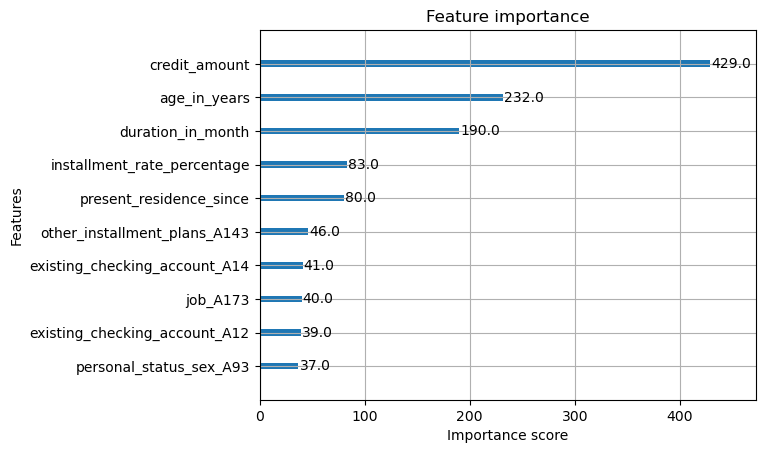

In [17]:
# For the PyTorch model, libraries like SHAP or LIME can be used to explain predictions.
# For XGBoost, we can easily get feature importances, which is a major advantage for interpretability.
# For example:
xgb.plot_importance(xgb_model, max_num_features=10)
# This shows which features the model found most predictive.